In [6]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import random
import threading

In [7]:
#hyper parameters
t_max = 10
gamma = 0.99
learning_rate = 0.001
beta = 0

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)


In [8]:
class policy_net(nn.Module):
    def __init__(self, input_feature, num_action):
        super(policy_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 128, out_features = num_action)
        

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.linear2(x)
        policy = F.softmax(x,dim=0)
        return policy
    
class value_net(nn.Module):
    def __init__(self, input_feature):
        super(value_net,self).__init__()
        self.linear1 = nn.Linear(in_features = input_feature, out_features = 128)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features = 128, out_features = 1)

        
    def forward(self,x):
        x = self.activation1(self.linear1(x))
        x = self.linear2(x)
        return x
    
    
    

In [9]:

def get_action(num_action, policy):
    return np.random.choice(num_action, 1, p=policy.detach().numpy()).item()



In [10]:
#multihtread
p_net_shared = policy_net(4,2)
v_net_shared = value_net(4)
np.random.seed(seed)
torch.manual_seed(seed)

reward_plot = [0 for i in range(5000)]

def training(idx):
    t_max = 5
    gamma = 0.9
    learning_rate = 0.001
    num_action = 2
    step = 0
    state = []
    beta = 0
    env = gym.make('CartPole-v0')

    global p_net_shared
    global v_net_shared
    p_optimizer = optim.Adam(p_net_shared.parameters(), lr=learning_rate)
    v_optimizer = optim.Adam(v_net_shared.parameters(), lr=learning_rate)
    global reward_plot
    
    for iteration in range(5000):
        done = False
        observation = env.reset()
        state = observation
        
        p_net = policy_net(4,num_action)
        v_net = value_net(4)
    
        p_net.zero_grad()
        v_net.zero_grad()
        
        t_update = 0
        #beta -= 0.0003
        #learning_rate -= 0.0009/2000
        if(iteration>2000):
            learning_rate = 0.0001
        if(beta<=0):
            beta = 0
        reward_stack = []
        prob_stack = []
        value_stack = []
        entropy = 0
        reward_sum = 0
        policy_loss_sum=0
        value_loss_sum = 0
        entropy_sum = 0
        for t in range(10000):

            step = step+1

            policy= p_net(torch.Tensor(state))
            value = v_net(torch.Tensor(state))
            action = get_action(num_action, policy)
            
            next_state , reward, done, info = env.step(action)

            reward_sum += reward
            t_update += 1

            reward_stack.append(reward)
            value_stack.append(value)
            prob_stack.append(policy[action])
            
            entropy += -torch.sum(policy * torch.log(torch.clamp(policy,min=1e-6)))

            if(t_update >= t_max or done):
                R = v_net(torch.Tensor(next_state))
                if(done):
                    R= 0
                policy_loss = 0
                value_loss = 0
                

                for i in range(t_update):
                    R = R*gamma + reward_stack.pop()
                    value_temp = value_stack.pop()
                    policy_loss += -torch.log(torch.clamp(prob_stack.pop(),min=1e-6)) * (R-value_temp).detach()
                    value_loss += (R-value_temp) * (R-value_temp)
                    
                entropy = -entropy * beta
                policy_loss = policy_loss + entropy 
                policy_loss = policy_loss / t_update
                value_loss = value_loss /t_update
                
                policy_loss.backward(retain_graph=True)
                value_loss.backward()
                policy_loss_sum += policy_loss.detach().numpy()
                value_loss_sum += value_loss.detach().numpy()
                update = 1
                for p_param , s_p_param , v_param , s_v_param in zip(p_net.parameters(), p_net_shared.parameters(), v_net.parameters(), v_net_shared.parameters()):
                    if(s_p_param.grad is not None and  s_p_param.grad.sum().detach().numpy() != 0):
                        update = 0
                        break
                    if(s_v_param.grad is not None and  s_v_param.grad.sum().detach().numpy() !=0):
                        update = 0
                        break
                    s_p_param._grad = p_param.grad.detach()
                    s_v_param._grad = v_param.grad.detach()
                    if((s_p_param != s_p_param).any()):
                        print("explode !!!! ")
                    
                if(update):
                    p_optimizer.step()
                    v_optimizer.step()
                    p_net_shared.zero_grad()
                    v_net_shared.zero_grad()
                
                p_net = policy_net(4,num_action)
                v_net = value_net(4)    

                p_net.load_state_dict(p_net_shared.state_dict())
                v_net.load_state_dict(v_net_shared.state_dict())
                R=0
                entropy = 0
                t_update = 0
            if(done):
                break

            #env.render()
            state = next_state[:]
        reward_plot[iteration] += reward_sum
        if(iteration%10 ==0):
            print(policy_loss_sum)
            print(value_loss_sum)
            print("training idx {} actor true_reward at iteration {} : {}".format(idx,iteration, reward_sum))
            print(step)
            beta = beta * 0.99
th1 = threading.Thread(target = training , args = (1,))
'''th2 = threading.Thread(target = training , args = (2,))
th3 = threading.Thread(target = training , args = (3,))
''''''th4 = threading.Thread(target = training , args = (4,))'''
th1.start()
'''th2.start()
th3.start()
''''''th4.start()'''

th1.join()
'''th2.join()
th3.join()
''''''th4.join()'''

print("finish")

[3.708804]
[16.662498]
training idx 1 actor true_reward at iteration 0 : 10.0
10
[6.045132]
[26.386707]
training idx 1 actor true_reward at iteration 10 : 19.0
207
[12.945839]
[55.682156]
training idx 1 actor true_reward at iteration 20 : 44.0
424
[2.7678044]
[14.868081]
training idx 1 actor true_reward at iteration 30 : 11.0
617
[8.059684]
[31.210052]
training idx 1 actor true_reward at iteration 40 : 30.0
856
[1.2999823]
[10.699327]
training idx 1 actor true_reward at iteration 50 : 10.0
1028
[2.5239751]
[16.233315]
training idx 1 actor true_reward at iteration 60 : 14.0
1226
[4.289885]
[17.02771]
training idx 1 actor true_reward at iteration 70 : 19.0
1424
[6.0453386]
[25.834301]
training idx 1 actor true_reward at iteration 80 : 28.0
1648
[3.427557]
[21.649254]
training idx 1 actor true_reward at iteration 90 : 21.0
1955
[3.6892626]
[14.08694]
training idx 1 actor true_reward at iteration 100 : 18.0
2154
[3.8326268]
[20.863337]
training idx 1 actor true_reward at iteration 110 : 23

[5.402196]
[20.578403]
training idx 1 actor true_reward at iteration 950 : 149.0
124120
[5.279699]
[20.219852]
training idx 1 actor true_reward at iteration 960 : 134.0
125627
[3.8221955]
[19.796394]
training idx 1 actor true_reward at iteration 970 : 143.0
127225
[3.8716571]
[19.83941]
training idx 1 actor true_reward at iteration 980 : 152.0
128632
[3.0602062]
[17.340254]
training idx 1 actor true_reward at iteration 990 : 134.0
130142
[9.363712]
[29.573252]
training idx 1 actor true_reward at iteration 1000 : 179.0
131760
[1.2209609]
[57.709496]
training idx 1 actor true_reward at iteration 1010 : 200.0
133722
[8.854573]
[26.713549]
training idx 1 actor true_reward at iteration 1020 : 200.0
135722
[6.7528877]
[25.384617]
training idx 1 actor true_reward at iteration 1030 : 200.0
137722
[5.037673]
[23.99031]
training idx 1 actor true_reward at iteration 1040 : 200.0
139722


KeyboardInterrupt: 

Text(0.5, 1.0, 'reward')

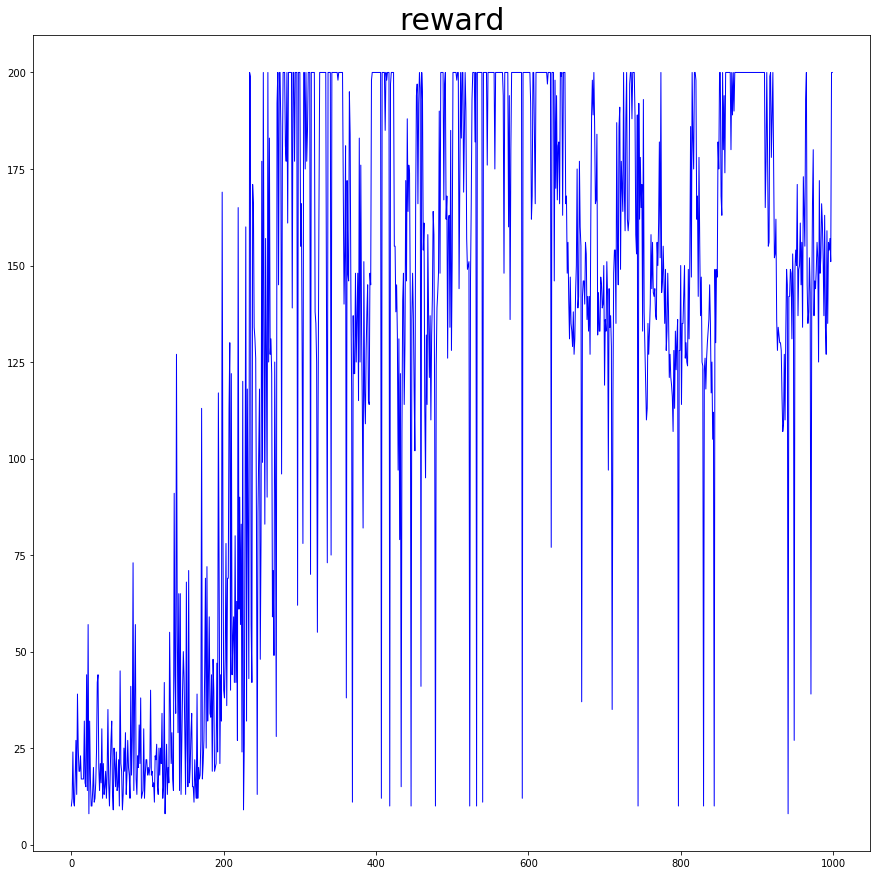

[7.651203]
[27.965067]
training idx 1 actor true_reward at iteration 1060 : 182.0
143685
[4.072]
[19.828363]
training idx 1 actor true_reward at iteration 1070 : 187.0
145316


In [11]:
reward_np = np.array(reward_plot[:1000]) 
fig, axe = plt.subplots(1, figsize = (15,15))
axe.plot(list(range(len(reward_np))),reward_np, lw = 1, label = 'reward', color = 'blue')
axe.set_title('reward', fontsize = 30)


In [11]:
#test
state = []
env = gym.make('Pendulum-v0')
done = False
reward_sum=0
observation = env.reset()
state = observation
num_action = 11

for t in range(10000):
    env.render()
    
    policy= p_net_shared(torch.Tensor(state))
    value = v_net_shared(torch.Tensor(state))

    action = get_action_idx(num_action, policy)
    action = -2 + 0.4 * action_idx
    obs , reward, done, info = env.step([action])
    
    
    reward_sum = reward_sum + reward
    state=obs
    if done:
        break
    
print("reward {}".format(reward_sum))

ValueError: probabilities contain NaN